**Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

**Data Handling**

In [4]:
# Paths
train_csv_path = '/content/drive/MyDrive/eyePACS/trainLabels.csv'
train_image_path = '/content/drive/MyDrive/eyePACS/train'
test_image_path = '/content/drive/MyDrive/eyePACS/test'
checkpoint_dir = '/content/drive/MyDrive/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [5]:
csv_path = '/content/drive/MyDrive/eyePACS/trainLabels.csv'

df = pd.read_csv(csv_path)

print("CSV Dataset Overview:")
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])
print("Columns:", df.columns.tolist())
print("\nSample data:")
print(df.head())

CSV Dataset Overview:
Number of rows: 35126
Number of columns: 2
Columns: ['image', 'level']

Sample data:
      image  level
0   10_left      0
1  10_right      0
2   13_left      0
3  13_right      0
4   15_left      1


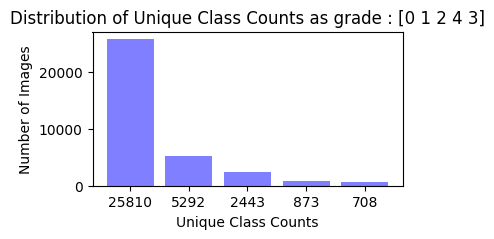

Number of images in each class:
Class 0: 25810 images
Class 2: 5292 images
Class 1: 2443 images
Class 3: 873 images
Class 4: 708 images


In [6]:
import pandas as pd
import matplotlib.pyplot as plt


class_counts = df['level'].value_counts()

unique_counts = class_counts.unique()

plt.figure(figsize=(4, 2))
plt.bar(range(len(unique_counts)), unique_counts, color='blue', alpha=0.5)

plt.xlabel('Unique Class Counts')
plt.ylabel('Number of Images')
plt.title('Distribution of Unique Class Counts as grade : [0 1 2 4 3]')

plt.xticks(range(len(unique_counts)), unique_counts)

plt.show()

print("Number of images in each class:")
for level, count in class_counts.items():
    print(f"Class {level}: {count} images")


Class distribution after undersampling: {0: 708, 1: 708, 2: 708, 3: 708, 4: 708}
Resampled class counts: {0: 708, 1: 708, 2: 708, 3: 708, 4: 708}


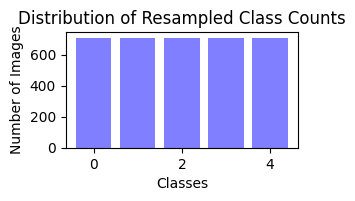

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

data = df

X = data['image']
y = data['level']

X_array = X.values.reshape(-1, 1)
y_array = y.values

class_counts = {0: 25810, 1: 2443, 2: 5292, 3: 873, 4: 708}
target_count = min(class_counts.values())

#undersampling
undersampler = RandomUnderSampler(sampling_strategy={label: target_count for label in class_counts.keys()})
X_under, y_under = undersampler.fit_resample(X_array, y_array)

print("Class distribution after undersampling:", dict(zip(*np.unique(y_under, return_counts=True))))

# Oversampling
oversampler = RandomOverSampler(sampling_strategy={label: target_count for label in np.unique(y_under)})
X_resampled, y_resampled = oversampler.fit_resample(X_under, y_under)

unique, counts = np.unique(y_resampled, return_counts=True)
resampled_class_counts = dict(zip(unique, counts))
print("Resampled class counts:", resampled_class_counts)

plt.figure(figsize=(3, 1.5))
plt.bar(resampled_class_counts.keys(), resampled_class_counts.values(), color='blue', alpha=0.5)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Resampled Class Counts')
plt.show()


In [8]:
new_X = []
for i in X_resampled:
  for j in i:
    new_X.append(j)

In [9]:
y_resampled

array([0, 0, 0, ..., 4, 4, 4])

In [10]:
resampled_data = {'image': new_X,
        'level': y_resampled}

balanced_data = pd.DataFrame(resampled_data)


balanced_data.sample(10)

,image,level
374,30060_right,0
366,42997_left,0
1522,43583_left,2
1419,31430_left,2
2099,41415_right,2
2002,31945_right,2
678,21173_left,0
700,34803_right,0
3079,20855_right,4
1541,33592_left,2


In [11]:
print(balanced_data.value_counts().sum())
print(balanced_data['level'].unique())
print(balanced_data['level'].value_counts().unique())

3540
[0 1 2 3 4]
[708]


In [12]:
balanced_data['image'] = balanced_data['image']+'.jpeg'
balanced_data['level'] = balanced_data['level'].astype(str)
balanced_data.head()

,image,level
0,37583_right.jpeg,0
1,35767_right.jpeg,0
2,4490_left.jpeg,0
3,4133_right.jpeg,0
4,7264_right.jpeg,0


In [13]:
train, val = train_test_split(balanced_data, test_size=0.2, random_state=42)

In [14]:
IMAGE_SIZE = (512, 512)
BATCH_SIZE = 32
NUM_CLASSES = 5

Number of samples in training set: 2832
Number of samples in validation set: 708
train 2832 validation 708


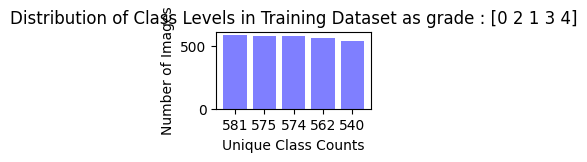

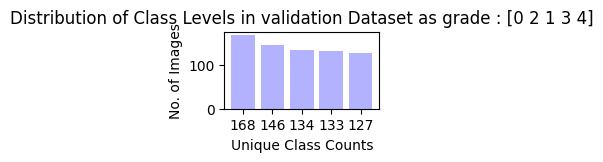

In [15]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(balanced_data, test_size=0.2, random_state=42)

print("Number of samples in training set:", len(train))
print("Number of samples in validation set:", len(val))

print('train', train.shape[0], 'validation', val.shape[0])

class_counts = train['level'].value_counts()
unique_counts = class_counts.unique()

plt.figure(figsize=(2, 1))
plt.bar(range(len(unique_counts)), unique_counts, color='blue', alpha=0.5)
plt.xlabel('Unique Class Counts')
plt.ylabel('Number of Images')
plt.title('Distribution of Class Levels in Training Dataset as grade : [0 2 1 3 4]')
plt.xticks(range(len(unique_counts)), unique_counts)
plt.show()


class_counts = val['level'].value_counts()
unique_counts = class_counts.unique()

plt.figure(figsize=(2, 1))
plt.bar(range(len(unique_counts)), unique_counts, color='blue', alpha=0.3)

plt.xlabel('Unique Class Counts')
plt.ylabel('No. of Images')
plt.title('Distribution of Class Levels in validation Dataset as grade : [0 2 1 3 4]')

plt.xticks(range(len(unique_counts)), unique_counts)

plt.show()

**Ben Graham's Preprocessing**

In [16]:
import cv2
import numpy as np
import os

def scale_radius(img, scale):
    """
    Scales the image to a specified radius.
    """
    x = img[img.shape[0] // 2, :, :].sum(1)
    r = (x > x.mean() / 10).sum() / 2
    s = scale * 1.0 / r
    return cv2.resize(img, (int(img.shape[1]*s), int(img.shape[0]*s)), interpolation=cv2.INTER_AREA)

def subtract_local_average_color(img):
    """
    Subtracts the local average color.
    """
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0),  10), -4, 128)
    return img

def clip_image(img, target_size=(512, 512)):
    """
    Clips the image to 90% size to remove boundary effects, and optionally applies resizing and normalization.
    """
    img_a = scale_radius(img, 300)
    img = subtract_local_average_color(img_a)
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    center = (img.shape[1] // 2, img.shape[0] // 2)
    radius = int(300 * 0.9)
    cv2.circle(mask, center, radius, 255, -1)
    img_masked = cv2.bitwise_and(img,img, mask=mask)
    img_resized = cv2.resize(img_masked, target_size)


    return img_resized


In [ ]:
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip = True,
    preprocessing_function=clip_image
)


train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=r'/content/drive/MyDrive/eyePACS/train',
    x_col='image',
    y_col='level',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


val_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip = True,
    preprocessing_function=clip_image

)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val,
    directory=r'/content/drive/MyDrive/eyePACS/train',
    x_col='image',
    y_col='level',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 2832 validated image filenames belonging to 5 classes.
Found 708 validated image filenames belonging to 5 classes.


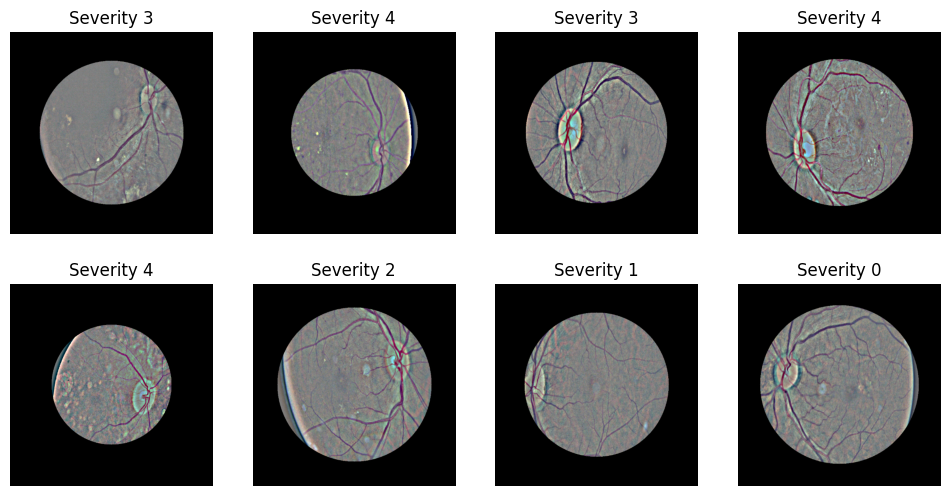

In [ ]:
t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(2, 4, figsize = (12, 6))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x)
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')

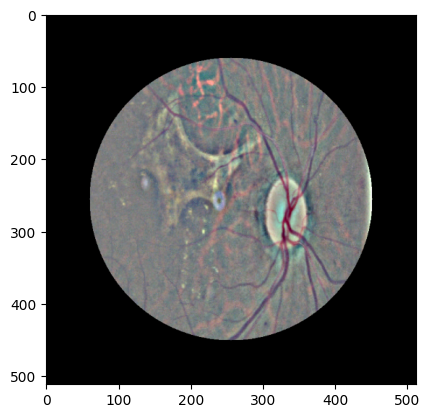

In [ ]:
plt.imshow(next(train_generator)[0][0])

**InceptionV3 model Training with callbacks**

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

for layer in inceptionv3.layers:
    layer.trainable = False

x = inceptionv3.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu', kernel_regularizer=l2( 0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(512, activation='relu', kernel_regularizer=l2( 0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

NUM_CLASSES = 5
inceptionv3_pred = Dense(NUM_CLASSES, activation='softmax')(x)

best_model_inceptionV3 = Model(inputs=inceptionv3.input, outputs=inceptionv3_pred)


best_model_inceptionV3.compile(
    optimizer=Adam(learning_rate=0.00010093485778680839),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

# Train the model
history_x = best_model_inceptionV3.fit(train_generator, validation_data=val_generator, epochs=100, batch_size=16, callbacks=callbacks)


Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1555s 16s/step - accuracy: 0.2793 - loss: 21.9357 - val_accuracy: 0.2486 - val_loss: 19.9238 - learning_rate: 1.0093e-04
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 723s 8s/step - accuracy: 0.3264 - loss: 19.6953 - val_accuracy: 0.2020 - val_loss: 18.3269 - learning_rate: 1.0093e-04
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 682s 7s/step - accuracy: 0.3741 - loss: 18.0038 - val_accuracy: 0.3545 - val_loss: 16.8683 - learning_rate: 1.0093e-04
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 671s 7s/step - accuracy: 0.3962 - loss: 16.6988 - val_accuracy: 0.3404 - val_loss: 15.6958 - learning_rate: 1.0093e-04
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 673s 7s/step - accuracy: 0.3723 - loss: 15.5062 - val_accuracy: 0.3856 - val_loss: 14.7397 - learning_rate: 1.0093e-04
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 672s 7s/step - accuracy: 0.3971 - loss: 14.5277 - val_accuracy: 0.3319 - val_loss: 14.1132 - learning_rate: 1.0093e-04
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 664s 7s/ste

In [ ]:
import os

model_directory = '/content/drive/MyDrive/ensemble_model'
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

model_save_path = os.path.join(model_directory, 'model_V3Xx.h5')

best_model_inceptionV3.save(model_save_path)

print("Model saved at:", model_save_path)

Model saved at: /content/drive/MyDrive/ensemble_model/model_V3Xx.h5


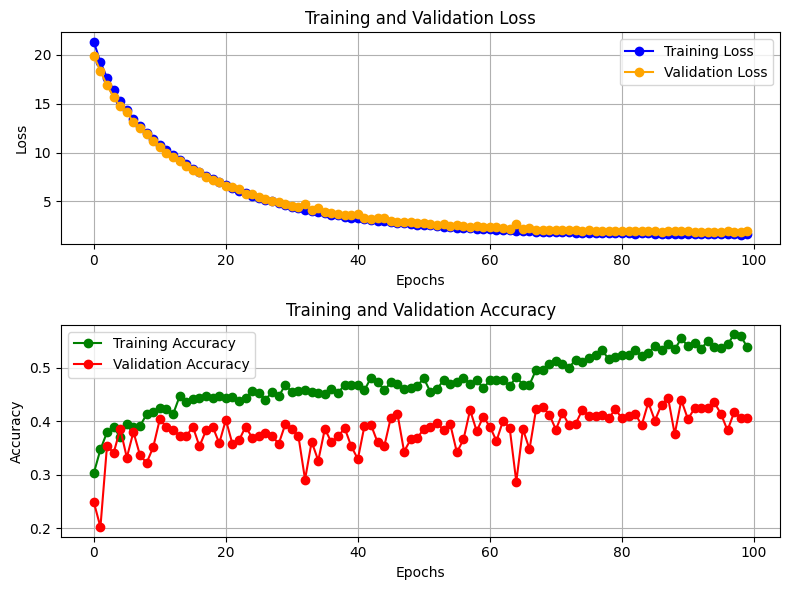

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(8, 6))

axes[0].plot(history_x.history['loss'], label='Training Loss', color='blue', marker='o')
axes[0].plot(history_x.history['val_loss'], label='Validation Loss', color='orange', marker='o')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(history_x.history['accuracy'], label='Training Accuracy', color='green', marker='o')
axes[1].plot(history_x.history['val_accuracy'], label='Validation Accuracy', color='red', marker='o')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
val_loss, val_accuracy = best_model_inceptionV3.evaluate(val_generator)

print("Validation Accuracy:", val_accuracy)

23/23 ━━━━━━━━━━━━━━━━━━━━ 136s 6s/step - accuracy: 0.4483 - loss: 1.8836
Validation Accuracy: 0.4138418138027191


In [ ]:
loss, accuracy = best_model_inceptionV3.evaluate(train_generator)
print("Training Loss:", loss)
print("Training Accuracy:", accuracy)


89/89 ━━━━━━━━━━━━━━━━━━━━ 548s 6s/step - accuracy: 0.5913 - loss: 1.5414
Training Loss: 1.5383570194244385
Training Accuracy: 0.5935734510421753


**ResNet50 with callback**

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

for layer in resnet50.layers:
    layer.trainable = False

x = resnet50.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

NUM_CLASSES = 5
resnet_pred = Dense(NUM_CLASSES, activation='softmax')(x)

best_model_resnet50 = Model(inputs=resnet50.input, outputs=resnet_pred)

best_model_resnet50.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

# Train the model
history = best_model_resnet50.fit(train_generator, validation_data=val_generator, epochs=100, batch_size=16, callbacks=callbacks)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/89 ━━━━━━━━━━━━━━━━━━━━ 3943s 41s/step - accuracy: 0.2044 - loss: 21.5007 - val_accuracy: 0.1893 - val_loss: 16.5790 - learning_rate: 1.0000e-04
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 708s 7s/step - accuracy: 0.2488 - loss: 16.1592 - val_accuracy: 0.1879 - val_loss: 13.3607 - learning_rate: 1.0000e-04
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 667s 7s/step - accuracy: 0.2545 - loss: 13.1301 - val_accuracy: 0.2048 - val_loss: 11.1132 - learning_rate: 1.0000e-04
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 688s 7s/step - accuracy: 0.2385 - loss: 11.2548 - val_accuracy: 0.2203 - val_loss: 9.8525 - learning_rate: 1.0000e-04
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 649s 7s/step - accuracy: 0.2504 - loss: 10.1215 - val_accuracy: 0.2387 - val_loss: 9.4567 - learning_rate: 1.0000e-04
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 706s 7s/step - accuracy: 0.2533 - loss: 9.3301 - val_accuracy: 0.2542 - val_loss: 8.7741 - learning_rate: 1.0000e-04
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 676s 7s/step - accuracy: 0.

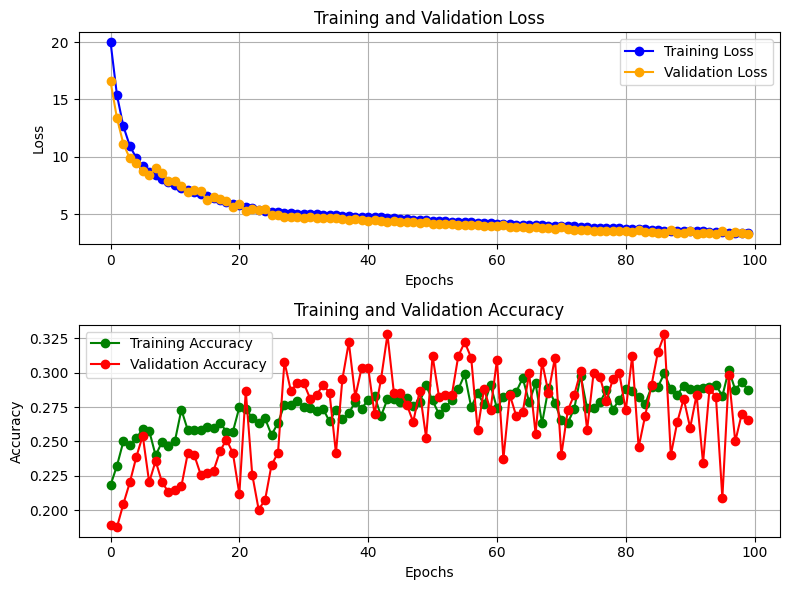

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(8, 6))

axes[0].plot(history.history['loss'], label='Training Loss', color='blue', marker='o')
axes[0].plot(history.history['val_loss'], label='Validation Loss', color='orange', marker='o')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(history.history['accuracy'], label='Training Accuracy', color='green', marker='o')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', marker='o')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model('/content/drive/MyDrive/ensemble_model/model_50Xx.h5')

val_loss, val_accuracy = loaded_model.evaluate(val_generator)

print(f"Validation Accuracy: {val_accuracy:.4f}")



/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 355s 15s/step - accuracy: 0.2969 - loss: 3.2064
Validation Accuracy: 0.3136


In [ ]:
import os

model_directory = '/content/drive/MyDrive/ensemble_model'
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

model_save_path = os.path.join(model_directory, 'model_50Xx.h5')

best_model_resnet50.save(model_save_path)

print("Model saved at:", model_save_path)


Model saved at: /content/drive/MyDrive/ensemble_model/model_50Xx.h5


**EfficientNet Model Training with callbacks**

In [ ]:
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


efficientnet_b5 = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

for layer in efficientnet_b5.layers:
    layer.trainable = False

x = efficientnet_b5.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.05)(x)


NUM_CLASSES = 5
efficientnet_b5_pred = Dense(NUM_CLASSES, activation='softmax')(x)

best_model_EfficientNetB5 = Model(inputs=efficientnet_b5.input, outputs=efficientnet_b5_pred)

best_model_EfficientNetB5.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

history_j = best_model_EfficientNetB5.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    batch_size=16,
    callbacks=callbacks
)

115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/89 ━━━━━━━━━━━━━━━━━━━━ 3943s 41s/step - accuracy: 0.1968 - loss: 21.6092 - val_accuracy: 0.1794 - val_loss: 18.7033 - learning_rate: 1.0000e-04
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 687s 7s/step - accuracy: 0.2147 - loss: 18.4347 - val_accuracy: 0.1879 - val_loss: 16.4064 - learning_rate: 1.0000e-04
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 676s 7s/step - accuracy: 0.1879 - loss: 16.2405 - val_accuracy: 0.1879 - val_loss: 14.7841 - learning_rate: 1.0000e-04
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 680s 7s/step - accuracy: 0.2108 - loss: 14.6499 - val_accuracy: 0.1879 - val_loss: 13.4919 - learning_rate: 1.0000e-04
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 677s 7s/step - accuracy: 0.2013 - loss: 13.4229 - val_accuracy: 0.1794 - val_loss: 12.5909 - learning_rate: 1.0000e-04
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 675s 7s/step - accuracy: 0.2017 - loss: 12.4769 - val_accuracy: 0.1794 - val_loss: 11.6680 - learning_rate: 1.0000e-04
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 683s 7s/step - accuracy

In [ ]:
import os

model_directory = '/content/drive/MyDrive/ensemble_model'
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

model_save_path = os.path.join(model_directory, 'model_B5Xx.h5')

best_model_EfficientNetB5.save(model_save_path)

print("Model saved at:", model_save_path)


Model saved at: /content/drive/MyDrive/ensemble_model/model_B5Xx.h5


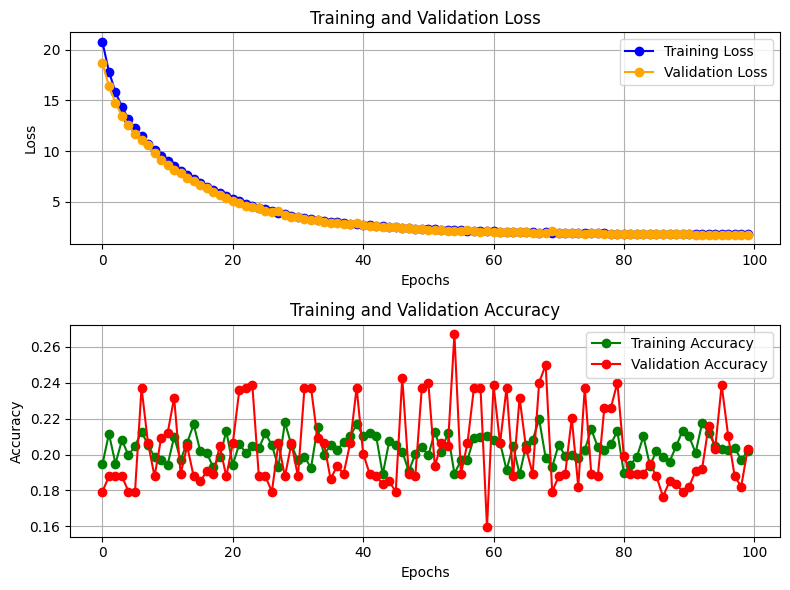

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(8, 6))

axes[0].plot(history_j.history['loss'], label='Training Loss', color='blue', marker='o')
axes[0].plot(history_j.history['val_loss'], label='Validation Loss', color='orange', marker='o')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(history_j.history['accuracy'], label='Training Accuracy', color='green', marker='o')
axes[1].plot(history_j.history['val_accuracy'], label='Validation Accuracy', color='red', marker='o')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
val_loss, val_accuracy = best_model_EfficientNetB5.evaluate(val_generator)

print("Validation loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

23/23 ━━━━━━━━━━━━━━━━━━━━ 138s 6s/step - accuracy: 0.1960 - loss: 1.7712
Validation loss: 1.7702447175979614
Validation Accuracy: 0.21327683329582214


In [ ]:
loss, accuracy = best_model_EfficientNetB5.evaluate(train_generator)

print("Training loss:", loss)
print("Training Accuracy:", accuracy)

89/89 ━━━━━━━━━━━━━━━━━━━━ 545s 6s/step - accuracy: 0.2396 - loss: 1.7662
Training loss: 1.7665287256240845
Training Accuracy: 0.23701871931552887


**DenseNet169 training with callbacks**

In [ ]:
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


densenet_169 = DenseNet169(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

for layer in densenet_169.layers:
    layer.trainable = False

x = densenet_169.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

NUM_CLASSES = 5
densenet_169_pred = Dense(NUM_CLASSES, activation='softmax')(x)

best_model_DenseNet169 = Model(inputs=densenet_169.input, outputs=densenet_169_pred)

best_model_DenseNet169.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]


history_i = best_model_DenseNet169.fit(train_generator, validation_data=val_generator, epochs=100, batch_size=16, callbacks=callbacks)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/89 ━━━━━━━━━━━━━━━━━━━━ 2594s 27s/step - accuracy: 0.2476 - loss: 20.7344 - val_accuracy: 0.3715 - val_loss: 16.8027 - learning_rate: 1.0000e-04
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 675s 7s/step - accuracy: 0.3363 - loss: 16.6626 - val_accuracy: 0.2712 - val_loss: 14.2790 - learning_rate: 1.0000e-04
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 680s 7s/step - accuracy: 0.3234 - loss: 14.1648 - val_accuracy: 0.3672 - val_loss: 12.5125 - learning_rate: 1.0000e-04
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 679s 7s/step - accuracy: 0.3383 - loss: 12.6405 - val_accuracy: 0.3941 - val_loss: 11.3116 - learning_rate: 1.0000e-04
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 682s 7s/step - accuracy: 0.3299 - loss: 11.6049 - val_accuracy: 0.3941 - val_loss: 10.5978 - learning_rate: 1.0000e-04
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 733s 7s/step - accuracy: 0.3717 - loss: 10.8476 - val_accuracy: 0.4435 - val_loss: 10.0477 - learning_rate: 1.0000e-04
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 670s 7s/step - accuracy

In [ ]:
import os

model_directory = '/content/drive/MyDrive/ensemble_model'
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

model_save_path = os.path.join(model_directory, 'model_169Xx.h5')

best_model_DenseNet169.save(model_save_path)

print("Model saved at:", model_save_path)


Model saved at: /content/drive/MyDrive/ensemble_model/model_169Xx.h5


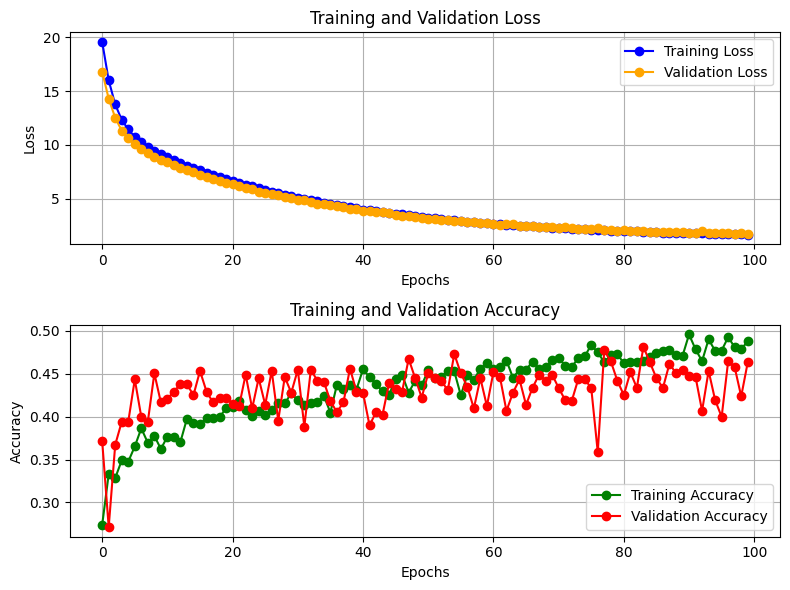

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(8, 6))

axes[0].plot(history_i.history['loss'], label='Training Loss', color='blue', marker='o')
axes[0].plot(history_i.history['val_loss'], label='Validation Loss', color='orange', marker='o')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend()


axes[1].plot(history_i.history['accuracy'], label='Training Accuracy', color='green', marker='o')
axes[1].plot(history_i.history['val_accuracy'], label='Validation Accuracy', color='red', marker='o')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
val_loss, val_accuracy = best_model_DenseNet169.evaluate(val_generator)
print("Validation loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

23/23 ━━━━━━━━━━━━━━━━━━━━ 129s 6s/step - accuracy: 0.4469 - loss: 1.7090
Validation loss: 1.700972080230713
Validation Accuracy: 0.4590395390987396


In [ ]:
loss, accuracy = best_model_DenseNet169.evaluate(train_generator)
print("Train loss:", loss)
print("Train Accuracy:", accuracy)

89/89 ━━━━━━━━━━━━━━━━━━━━ 550s 6s/step - accuracy: 0.5172 - loss: 1.5609
Train loss: 1.5636757612228394
Train Accuracy: 0.5135994553565979


**Ensemble Model**

In [ ]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


In [ ]:
import os

# Define the directory path
checkpoint_dir = '/content/drive/MyDrive/ensemble_model/'

# Create the directory if it doesn't exist
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Concatenate, BatchNormalization, Lambda
from keras_tuner import HyperModel
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.models import load_model

# Load the trained models (adjust the paths to where your models are saved)
best_model_V3 = load_model('/content/drive/MyDrive/ensemble_model/model_V3Xx.h5')
best_model_ResNet = load_model('/content/drive/MyDrive/ensemble_model/model_50Xx.h5')
best_model_EfficientNetB5 = load_model('/content/drive/MyDrive/ensemble_model/model_B5Xx.h5')
best_model_DenseNet169 = load_model('/content/drive/MyDrive/ensemble_model/model_169Xx.h5')

# Rename the layers in each model to avoid name conflicts
def rename_layers(model, prefix):
    config = model.get_config()
    for layer in config['layers']:
        layer['config']['name'] = f"{prefix}_{layer['config']['name']}"
    new_model = Model.from_config(config)
    for new_layer, layer in zip(new_model.layers, model.layers):
        try:
            new_layer.set_weights(layer.get_weights())
        except:
            pass
    return new_model

resnet50_model = rename_layers(best_model_ResNet, 'resnet')
inception_v3_model = rename_layers(best_model_V3, 'inception')
efficientnet_b5_model = rename_layers(best_model_EfficientNetB5, 'efficientnet')
densenet169_model = rename_layers(best_model_DenseNet169, 'densenet')

# Define the hypermodel class
class EnsembleHyperModel(HyperModel):
    def __init__(self, resnet50_model, inception_v3_model, efficientnet_b5_model, densenet169_model):
        self.resnet50_model = resnet50_model
        self.inception_v3_model = inception_v3_model
        self.efficientnet_b5_model = efficientnet_b5_model
        self.densenet169_model = densenet169_model

    def build(self):
        for layer in self.resnet50_model.layers:
            layer.trainable = False

        for layer in self.inception_v3_model.layers:
            layer.trainable = False

        for layer in self.efficientnet_b5_model.layers:
            layer.trainable = False

        for layer in self.densenet169_model.layers:
            layer.trainable = False

        # Remove the top layers from each model
        resnet50_output = self.resnet50_model.layers[-4].output
        inception_v3_output = self.inception_v3_model.layers[-4].output
        efficientnet_b5_output = self.efficientnet_b5_model.layers[-4].output
        densenet169_output = self.densenet169_model.layers[-4].output

        # Print the shape of the output tensors
        print("ResNet50 output shape:", resnet50_output.shape)
        print("Inception V3 output shape:", inception_v3_output.shape)
        print("EfficientNet B5 output shape:", efficientnet_b5_output.shape)
        print("DenseNet169 output shape:", densenet169_output.shape)

        combined = Concatenate()([resnet50_output, inception_v3_output, efficientnet_b5_output, densenet169_output])

        # Add new dense layers with L2 regularization and dropout
        x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.05))(combined)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.05))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)

        # Output layer
        NUM_CLASSES = 5  # Define the number of classes
        final_output = Dense(NUM_CLASSES, activation='softmax')(x)

        # Create the new model
        ensemble_model = Model(inputs=[
            self.resnet50_model.input,
            self.inception_v3_model.input,
            self.efficientnet_b5_model.input,
            self.densenet169_model.input
        ], outputs=final_output)

        # Compile the model
        learning_rate = 0.001
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        ensemble_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        return ensemble_model

# Initialize the hypermodel
hypermodel = EnsembleHyperModel(resnet50_model, inception_v3_model, efficientnet_b5_model, densenet169_model)
ensemble_model = hypermodel.build()

# Custom generator function
def multi_input_generator(generator):
    while True:
        x, y = next(generator)
        yield (x, x, x, x), (y)

# Wrap the generators with the custom multi-input generator
train_multi_input_gen = multi_input_generator(train_generator)
val_multi_input_gen = multi_input_generator(val_generator)

# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'ensemble_model_best.keras'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    checkpoint_callback
]



# Train the best model
history_10=ensemble_model.fit(train_multi_input_gen, validation_data=val_multi_input_gen, epochs=60,
                   steps_per_epoch=len(train_generator)//16, validation_steps=len(val_generator)//16, batch_size=16, callbacks=callbacks)


ResNet50 output shape: (None, 512)
Inception V3 output shape: (None, 512)
EfficientNet B5 output shape: (None, 512)
DenseNet169 output shape: (None, 512)
Epoch 1/60
5/5 ━━━━━━━━━━━━━━━━━━━━ 280s 42s/step - accuracy: 0.2871 - loss: 102.6063 - val_accuracy: 0.2500 - val_loss: 94.4098 - learning_rate: 0.0010
Epoch 2/60
5/5 ━━━━━━━━━━━━━━━━━━━━ 145s 36s/step - accuracy: 0.3254 - loss: 93.4368 - val_accuracy: 0.4062 - val_loss: 85.9212 - learning_rate: 0.0010
Epoch 3/60
5/5 ━━━━━━━━━━━━━━━━━━━━ 152s 36s/step - accuracy: 0.2986 - loss: 84.1838 - val_accuracy: 0.3438 - val_loss: 76.7611 - learning_rate: 0.0010
Epoch 4/60
5/5 ━━━━━━━━━━━━━━━━━━━━ 151s 36s/step - accuracy: 0.3043 - loss: 75.7062 - val_accuracy: 0.2188 - val_loss: 69.6906 - learning_rate: 0.0010
Epoch 5/60
5/5 ━━━━━━━━━━━━━━━━━━━━ 148s 35s/step - accuracy: 0.3852 - loss: 67.5520 - val_accuracy: 0.5000 - val_loss: 61.3592 - learning_rate: 0.0010
Epoch 6/60
5/5 ━━━━━━━━━━━━━━━━━━━━ 158s 38s/step - accuracy: 0.3425 - loss: 60.5138 

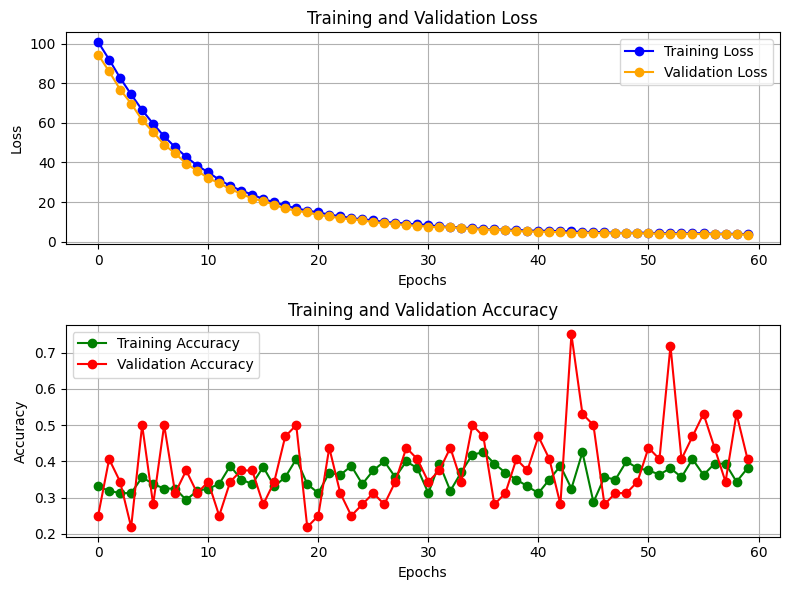

In [ ]:
import matplotlib.pyplot as plt

# Create subplots for loss and accuracy
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

# Plot training and validation loss
axes[0].plot(history_10.history['loss'], label='Training Loss', color='blue', marker='o')
axes[0].plot(history_10.history['val_loss'], label='Validation Loss', color='orange', marker='o')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend()

# Plot training and validation accuracy
axes[1].plot(history_10.history['accuracy'], label='Training Accuracy', color='green', marker='o')
axes[1].plot(history_10.history['val_accuracy'], label='Validation Accuracy', color='red', marker='o')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
val_loss, val_accuracy = ensemble_model.evaluate(val_multi_input_gen, steps=len(val_generator))

print("Validation Accuracy:", val_accuracy)
print("Validation Loss:", val_loss)

23/23 ━━━━━━━━━━━━━━━━━━━━ 155s 7s/step - accuracy: 0.4022 - loss: 3.6187
Validation Accuracy: 0.3997175097465515
Validation Loss: 3.6384854316711426


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

# Load the saved model
ensemble_model = load_model('/content/drive/MyDrive/ensemble_model/ensemble_model_best.keras')

# Set a new learning rate for the optimizer
new_learning_rate = 2.0000e-04  # Set the new learning rate

# Re-compile the model with the new learning rate
optimizer = Adam(learning_rate=new_learning_rate)
ensemble_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
def multi_input_generator(generator):
    while True:
        x, y = next(generator)
        yield (x, x, x, x), (y)

# Wrap the generators with the custom multi-input generator
train_multi_input_gen = multi_input_generator(train_generator)
val_multi_input_gen = multi_input_generator(val_generator)


callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]


# Continue training for more epochs with the adjusted learning rate
history = ensemble_model.fit(
    train_multi_input_gen,
    validation_data=val_multi_input_gen,
    epochs=40,
    steps_per_epoch=len(train_generator) // 16,
    validation_steps=len(val_generator) // 16,
    batch_size=16,
    callbacks=callbacks
)


Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 339s 31s/step - accuracy: 0.4576 - loss: 3.7098 - val_accuracy: 0.3125 - val_loss: 3.6610 - learning_rate: 2.0000e-04
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 10s/step - accuracy: 0.3556 - loss: 3.7486 - val_accuracy: 0.2812 - val_loss: 3.3973 - learning_rate: 2.0000e-04
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 73s 15s/step - accuracy: 0.3128 - loss: 3.7865 - val_accuracy: 0.3750 - val_loss: 3.1982 - learning_rate: 2.0000e-04
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 73s 15s/step - accuracy: 0.4676 - loss: 3.3717 - val_accuracy: 0.3750 - val_loss: 3.1849 - learning_rate: 2.0000e-04
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 71s 15s/step - accuracy: 0.3632 - loss: 3.4151 - val_accuracy: 0.5000 - val_loss: 3.1238 - learning_rate: 2.0000e-04
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 73s 15s/step - accuracy: 0.3702 - loss: 3.4251 - val_accuracy: 0.4375 - val_loss: 3.0681 - learning_rate: 2.0000e-04
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 70s 13s/step - accuracy: 0.3236 - loss: 3.470

In [ ]:
import os

# Define the directory and file path
model_directory = '/content/drive/MyDrive/ensemble_model'
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

model_save_path = os.path.join(model_directory, 'ensemble_model_bgx.keras')

# Save the model
ensemble_model.save(model_save_path)

# Print the path of the saved model
print("Model saved at:", model_save_path)


Model saved at: /content/drive/MyDrive/ensemble_model/ensemble_model_bgx.keras


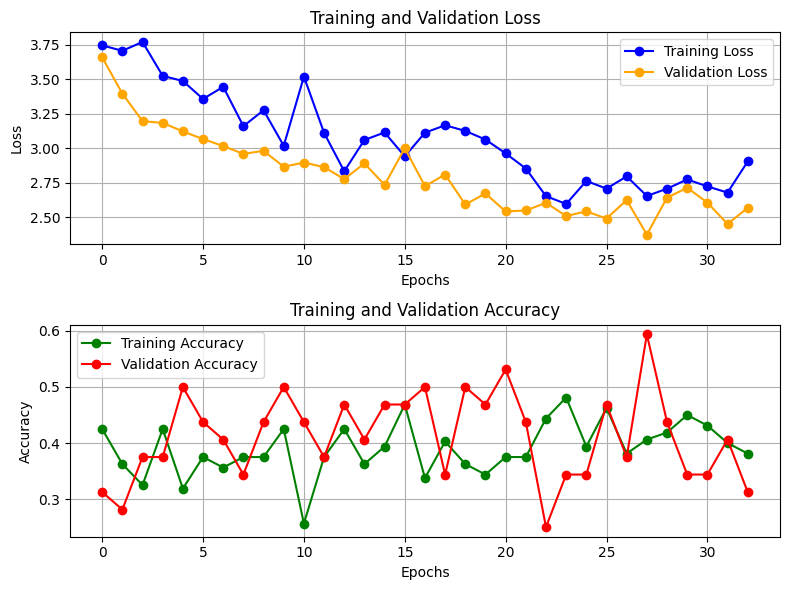

In [ ]:
import matplotlib.pyplot as plt

# Create subplots for loss and accuracy
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

# Plot training and validation loss
axes[0].plot(history.history['loss'], label='Training Loss', color='blue', marker='o')
axes[0].plot(history.history['val_loss'], label='Validation Loss', color='orange', marker='o')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend()

# Plot training and validation accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy', color='green', marker='o')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', marker='o')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
val_loss, val_accuracy = ensemble_model.evaluate(val_multi_input_gen, steps=len(val_generator))

print("Validation Accuracy:", val_accuracy)
print("Validation Loss:", val_loss)

23/23 ━━━━━━━━━━━━━━━━━━━━ 169s 8s/step - accuracy: 0.4451 - loss: 2.5150
Validation Accuracy: 0.4378530979156494
Validation Loss: 2.5052804946899414


**Evaluation**

In [ ]:
def multi_input_generator(generator):
    while True:
        x, y = next(generator)
        yield (x, x, x, x), (y)

# Wrap the generators with the custom multi-input generator
train_multi_input_gen = multi_input_generator(train_generator)
val_multi_input_gen = multi_input_generator(val_generator)

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

# Load the saved model
model_save_path = '/content/drive/MyDrive/ensemble_model/ensemble_model_bgx.keras'
ensemble_model = load_model(model_save_path)

batch_size = 16
all_predictions = []

true_Y_labels = []

for i in range(len(val_generator)):
    x_batch, y_batch = next(val_multi_input_gen)
    batch_predictions = ensemble_model.predict(x_batch)
    all_predictions.append(batch_predictions)
    true_Y_labels.append(y_batch)
pred_Y = np.concatenate(all_predictions)
true_Y = np.concatenate(true_Y_labels)

pred_Y_labels = np.argmax(pred_Y, axis=1)
true_Y_labels = np.argmax(true_Y, axis=1)

report = classification_report(true_Y_labels, pred_Y_labels, target_names=["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"])

print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 141s 141s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 60s 60s/step
              precision    recall  f1-score   support

     Class 0       0.41      0.33      0.37       168
     Class 1       0.34      0.39      0.37       133
   

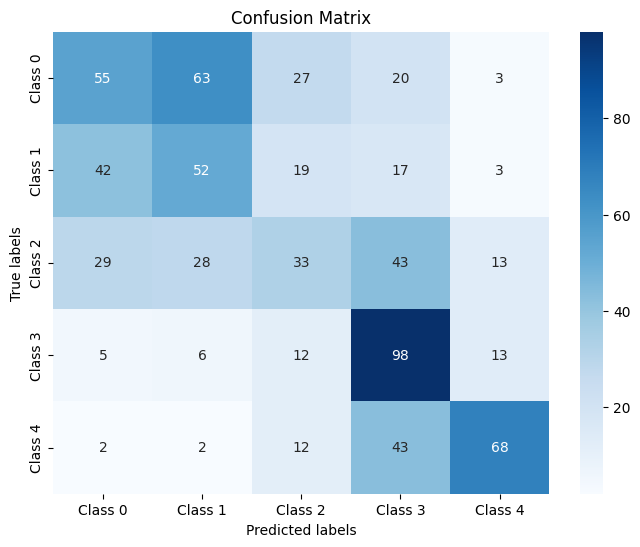

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(true_Y_labels, pred_Y_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"], yticklabels=["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


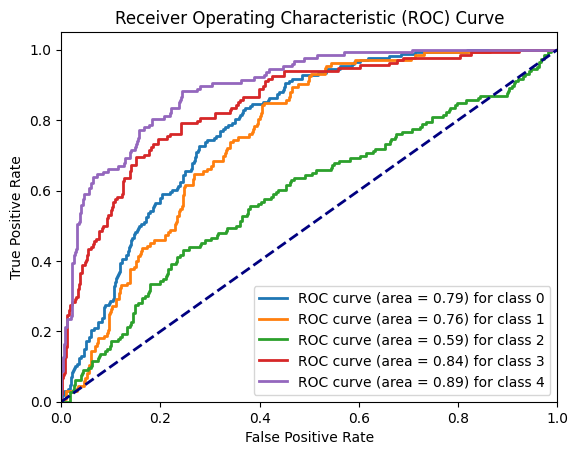

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(true_Y_labels, pred_Y[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
